In [20]:
import pandas as pd
import torch
import os
from matplotlib import pyplot as plt
from main import target_renamer, forecast_maker, data_slicer
from Models.lstm import LSTM
from Data.Featurisation import Featurisation

In [21]:
lags = 24
forecast_period=24
hidden_size = 100
num_layers = 4
dropout = 0.3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
month_data = False #1 month of data for testing new code

month_range = pd.date_range("2018-08-01", "2018-08-31 23:00", freq='h', tz="UTC")
source_range = pd.date_range("2016-05-01","2019-12-31 23:00", freq='h', tz="UTC")
target_month = pd.date_range("2020-08-01", "2020-08-31 23:00", freq='h', tz="UTC")
eval_month = pd.date_range("2021-07-01", "2021-07-31 23:00", tz="UTC", freq='h')


# 0. Data initialization

In [23]:
openmeteo = pd.read_pickle("Data/openmeteo.pickle")

pvgis = pd.read_pickle('Data/PVGIS.pickle')

CEDA = pd.read_pickle("CEDA_dataNL.pickle")

meteo2CEDA = {'temperature_2m' :'temperature_1_5m', 
              "relative_humidity_2m":"relative_humidity_1_5m", 
              "pressure_msl": "pressure_MSL",
              "cloud_cover":"total_cloud_amount",
              "shortwave_radiation_instant": "downward_surface_SW_flux",
              "diffuse_radiation_instant":"diffuse_surface_SW_flux",
              "direct_normal_irradiance_instant":"direct_surface_SW_flux",
              "wind_speed_10m": "wind_speed_10m",
              "wind_direction_10m": "wind_direction_10m"
              }
openmeteo = openmeteo.rename(columns=meteo2CEDA)


In [24]:
installation_id = "3437BD60"
prodNL = pd.read_parquet('Data/production.parquet', engine='pyarrow')
metadata = pd.read_csv("Data/installations Netherlands.csv", sep=';')
metadata = metadata.set_index('id')
metadata_id = metadata.loc[installation_id]
tilt = metadata_id["Tilt"]
peakPower = metadata_id["Watt Peak"]
azimuth = metadata_id["Orientation"]
latitude = metadata_id["Latitude"]
longitude = metadata_id["Longitude"]
power = prodNL.loc[installation_id]
power = target_renamer(power, 'watt')
power = power.resample('h').sum()/4
power = power.tz_localize('UTC')
print(latitude, longitude, peakPower, azimuth, tilt)
print(power)


52.0499 5.07391 3100 5 33
                               P
timestamp                       
2019-01-10 15:00:00+00:00    0.0
2019-01-10 16:00:00+00:00    0.0
2019-01-10 17:00:00+00:00    0.0
2019-01-10 18:00:00+00:00    0.0
2019-01-10 19:00:00+00:00    0.0
...                          ...
2021-08-09 16:00:00+00:00  954.0
2021-08-09 17:00:00+00:00  337.0
2021-08-09 18:00:00+00:00  100.0
2021-08-09 19:00:00+00:00    5.0
2021-08-09 20:00:00+00:00    0.0

[22614 rows x 1 columns]


In [25]:
#target and evaluation data will stay the same most probablyy
target_CEDA = data_slicer(CEDA, target_month)
target_power = data_slicer(power, target_month)
eval_CEDA = data_slicer(CEDA, eval_month)
eval_power = data_slicer(power, eval_month)
print(eval_power)

#TARGET DATASET
target_dataset = pd.merge(target_power, target_CEDA, left_index=True, right_index=True, how='inner')
data = [target_dataset] # Put it in a list to work with featurisation object

#2. Featurise data & ready for training & testing 7
data = Featurisation(data)
data.data = data.cyclic_features()
data.data = data.add_shift('P')
data.data = data.cyclic_angle('wind_direction_10m')

target_dataset = data.data[0]

## EVALUATION DATASET
eval_dataset = pd.merge(eval_power, eval_CEDA, left_index=True, right_index=True, how='inner')
data = [eval_dataset] # Put it in a list to work with featurisation object

#2. Featurise data & ready for training & testing 7
data = Featurisation(data)
data.data = data.cyclic_features()
data.data = data.add_shift('P')
data.data = data.cyclic_angle('wind_direction_10m')

eval_dataset = data.data[0]
print(eval_dataset)


                              P
timestamp                      
2021-07-01 00:00:00+00:00   0.0
2021-07-01 01:00:00+00:00   0.0
2021-07-01 02:00:00+00:00   0.0
2021-07-01 03:00:00+00:00   0.0
2021-07-01 04:00:00+00:00  20.0
...                         ...
2021-07-31 19:00:00+00:00  27.0
2021-07-31 20:00:00+00:00   0.0
2021-07-31 21:00:00+00:00   0.0
2021-07-31 22:00:00+00:00   0.0
2021-07-31 23:00:00+00:00   0.0

[744 rows x 1 columns]
                              P  temperature_1_5m  relative_humidity_1_5m  \
2021-07-01 00:00:00+00:00   0.0        286.683105               94.161896   
2021-07-01 01:00:00+00:00   0.0        286.683105               94.161896   
2021-07-01 02:00:00+00:00   0.0        286.466553               94.036751   
2021-07-01 03:00:00+00:00   0.0        286.465088               93.342484   
2021-07-01 04:00:00+00:00  20.0        286.359863               92.013138   
...                         ...               ...                     ...   
2021-07-31 19:00:00+0

# 1. NWP data

Case study 1:
|   | Source   | Target |
|---|----------|--------|
| X | CEDA | CEDA|
| Y | PVGIS    | Prod NL|

In [26]:
from Data.Featurisation import Featurisation

source_pvgis = data_slicer(pvgis, source_range)
source_CEDA = data_slicer(CEDA, source_range)


data = pd.merge(source_pvgis, source_CEDA, left_index=True, right_index=True)

data = [data] # Put it in a list to work with featurisation object

#2. Featurise data & ready for training & testing 7
data = Featurisation(data)
data.data = data.cyclic_features()
data.data = data.add_shift('P')


source_dataset = data.data[0]
if month_data:
    source_dataset = source_dataset[source_dataset.index.isin(month_range)]
print(source_dataset)

                             P  temperature_1_5m  relative_humidity_1_5m  \
2018-08-03 00:00:00+00:00  0.0        290.153564               89.562218   
2018-08-03 01:00:00+00:00  0.0        290.153564               89.562218   
2018-08-03 02:00:00+00:00  0.0        289.722656               91.335602   
2018-08-03 03:00:00+00:00  0.0        289.439697               92.918396   
2018-08-03 04:00:00+00:00  0.0        289.352783               91.971977   
...                        ...               ...                     ...   
2018-08-31 19:00:00+00:00  0.0        288.173096               74.732742   
2018-08-31 20:00:00+00:00  0.0        287.844971               75.033867   
2018-08-31 21:00:00+00:00  0.0        287.416016               74.860329   
2018-08-31 22:00:00+00:00  0.0        286.557617               74.826218   
2018-08-31 23:00:00+00:00  0.0        285.846680               72.743080   

                           total_cloud_amount  diffuse_surface_SW_flux  \
2018-08-03 00

In [27]:
tuning_method = 'freeze'
features = list(source_dataset.columns)
print(features)

['P', 'temperature_1_5m', 'relative_humidity_1_5m', 'total_cloud_amount', 'diffuse_surface_SW_flux', 'direct_surface_SW_flux', 'downward_surface_SW_flux', 'pressure_MSL', 'wind_speed_10m', 'wind_direction_10m', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'P_24h_shift']


Shape of data:  torch.Size([22, 24, 14]) torch.Size([6, 24, 14]) torch.Size([22, 24, 1]) torch.Size([6, 24, 1])
LSTM(
  (lstm): LSTM(14, 100, num_layers=5, batch_first=True, dropout=0.3)
  (linear): Linear(in_features=100, out_features=24, bias=True)
)
Step 0: Average train loss: 0.1201 | Average test loss: 0.0736
Step 5: Average train loss: 0.0846 | Average test loss: 0.0429
Step 10: Average train loss: 0.0392 | Average test loss: 0.0377
Step 15: Average train loss: 0.0262 | Average test loss: 0.0179
Step 20: Average train loss: 0.0246 | Average test loss: 0.0220
Step 25: Average train loss: 0.0232 | Average test loss: 0.0210
Step 30: Average train loss: 0.0224 | Average test loss: 0.0168
Step 35: Average train loss: 0.0219 | Average test loss: 0.0176
Step 40: Average train loss: 0.0197 | Average test loss: 0.0171
Step 45: Average train loss: 0.0154 | Average test loss: 0.0147
Step 50: Average train loss: 0.0131 | Average test loss: 0.0254
Step 55: Average train loss: 0.0120 | Average

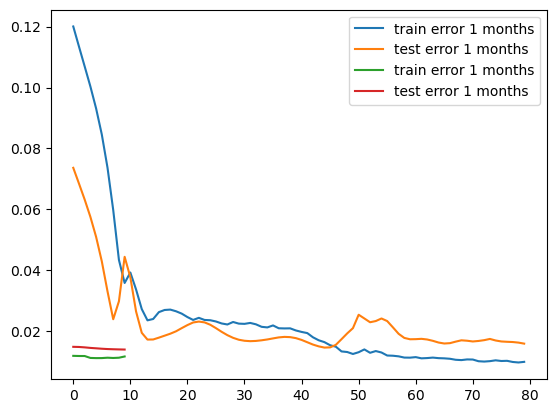

In [28]:
source_state_dict, target_state_dict, y_truth, y_forecast = forecast_maker(source_dataset, target_dataset, tuning_method, features, eval_dataset)

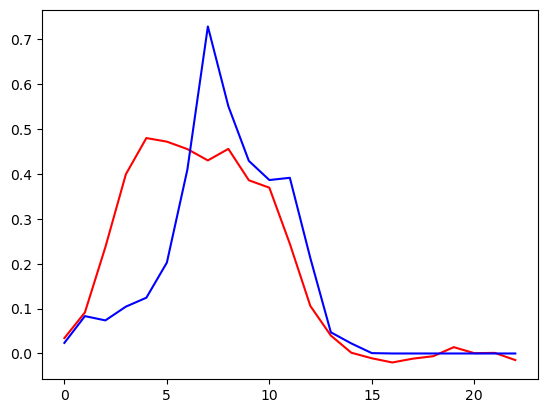

In [29]:
range = pd.date_range("2021-08-05", "2021-08-08", freq='h', tz='UTC')

plt.figure()

day = 5
plt.plot(y_forecast[day:day+23], color='red')
plt.plot(y_truth[day:day+23], color='blue')

# 2. Historic weather 

Case study 1:
|   | Source   | Target |
|---|----------|--------|
| X |open-meteo| CEDA|
| Y | PVGIS    | Prod NL|

In [30]:
# SOURCE DATA
data = pd.merge(pvgis, openmeteo, left_index=True, right_index=True)

data = [data] # Put it in a list to work with featurisation object

#2. Featurise data & ready for training & testing 7
data = Featurisation(data)
data.data = data.cyclic_features()
data.data = data.add_shift('P')
data.data = data.cyclic_angle('wind_direction_10m')



source_dataset = data.data[0]
if month_data:
    source_dataset = source_dataset[source_dataset.index.isin(month_range)]




In [31]:
# P = source_dataset['P']
# P_24h= source_dataset["P_24h_shift"]
# daterange = pd.date_range("2018-07-02", "2018-07-06", freq='h', tz="UTC")
# plt.figure()
# plt.plot(daterange, P[daterange],color="#11aa00", label="Actual power")
# plt.plot(daterange, P_24h[daterange], color="#11aa0055", label="Power 24h shifted")
# plt.legend()

In [32]:
tuning_method = 'whole'
source_features = list(source_dataset.columns)
print(source_features)


['P', 'temperature_1_5m', 'relative_humidity_1_5m', 'pressure_MSL', 'total_cloud_amount', 'downward_surface_SW_flux', 'diffuse_surface_SW_flux', 'direct_surface_SW_flux', 'wind_speed_10m', 'wind_direction_10m', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'P_24h_shift', 'wind_direction_10m_cos', 'wind_direction_10m_sin']


Shape of data:  torch.Size([24, 24, 16]) torch.Size([6, 24, 16]) torch.Size([24, 24, 1]) torch.Size([6, 24, 1])
LSTM(
  (lstm): LSTM(16, 100, num_layers=5, batch_first=True, dropout=0.3)
  (linear): Linear(in_features=100, out_features=24, bias=True)
)
Step 0: Average train loss: 0.1274 | Average test loss: 0.0703
Step 5: Average train loss: 0.0874 | Average test loss: 0.0367
Step 10: Average train loss: 0.0412 | Average test loss: 0.0386
Step 15: Average train loss: 0.0285 | Average test loss: 0.0178
Step 20: Average train loss: 0.0254 | Average test loss: 0.0264
Step 25: Average train loss: 0.0236 | Average test loss: 0.0229
Step 30: Average train loss: 0.0236 | Average test loss: 0.0195
Step 35: Average train loss: 0.0222 | Average test loss: 0.0228
Step 40: Average train loss: 0.0180 | Average test loss: 0.0205
Step 45: Average train loss: 0.0130 | Average test loss: 0.0263
Step 50: Average train loss: 0.0127 | Average test loss: 0.0295
Step 55: Average train loss: 0.0118 | Average

ValueError: too many values to unpack (expected 2)

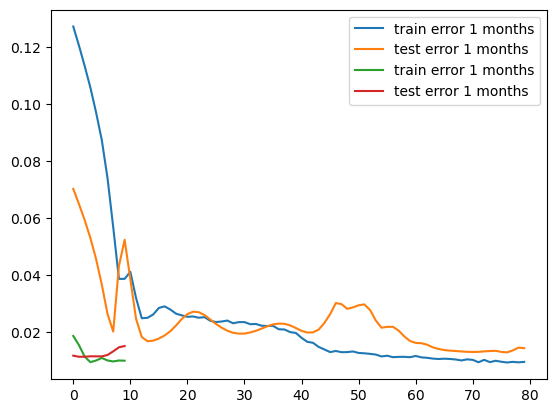

In [33]:
source_state_dict, target_state_dict = forecast_maker(source_dataset, target_dataset, tuning_method, source_features, eval_dataset)

In [ ]:
#Check data leakage (not robust lol)
input_weights = [0]*16
for i in range(0,16):
    input_weights[i] = abs(target_state_dict['lstm.weight_ih_l0'][:,i]).sum()
print(input_weights)

NameError: name 'target_state_dict' is not defined

In [ ]:
target_state_dict

OrderedDict([('lstm.weight_ih_l0',
              tensor([[-5.0855e-02, -7.4760e-02,  6.4156e-02,  ...,  9.4877e-02,
                        4.7339e-02,  3.0834e-02],
                      [-5.5332e-02, -2.3855e-02,  8.1275e-02,  ...,  1.4421e-01,
                       -6.5736e-02,  1.4232e-01],
                      [ 2.5026e-02, -1.0310e-02, -7.1007e-02,  ...,  3.1268e-03,
                       -8.6470e-03,  6.8979e-02],
                      ...,
                      [ 9.4081e-03, -4.9797e-02,  7.5537e-02,  ...,  2.3794e-03,
                        1.0036e-01, -4.3145e-02],
                      [ 1.3064e-01,  8.5841e-03, -3.1183e-02,  ...,  8.1157e-03,
                        1.6671e-01, -7.6433e-03],
                      [ 7.8506e-02, -1.9936e-02, -9.8509e-03,  ..., -1.0539e-04,
                       -5.5882e-02, -4.7572e-02]])),
             ('lstm.weight_hh_l0',
              tensor([[-0.0439,  0.0169, -0.0989,  ..., -0.0339, -0.0225,  0.0961],
                      [ 0.0684